In [5]:
!pip install selenium pandas webdriver-manager

In [7]:
import time
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager

# Инициализация Selenium-драйвера
def init_driver(headless=False):
    options = Options()
    if headless:
        options.add_argument('--headless')
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    options.add_argument("--lang=ru-RU")

    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=options)
    return driver


In [35]:
from selenium.common.exceptions import NoSuchElementException, TimeoutException
import random
from datetime import datetime, timedelta
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Настройки
MAX_RETRIES = 3
SCROLL_ATTEMPTS = 25
WAIT_TIME = 2
DRIVER_TIMEOUT = 30
HEADLESS = False

# Словарь филиалов (вставьте свои URL и названия)
LOCATIONS = {
    "https://www.google.com/maps/place/%D0%A6%D0%95%D0%A585/@59.9651067,30.2251694,13z/data=!4m10!1m2!2m1!1z0YbQtdGFODU!3m6!1s0x469631329ec7ab11:0x611e44e0e4e96379!8m2!3d59.9578293!4d30.3103608!15sCgjRhtC10YU4NSIDiAEBWgoiCNGG0LXRhTg1kgEGYmFrZXJ5qgFOCg0vZy8xMWo4cHI0NWN4EAEqDCII0YbQtdGFODUoDTIfEAEiG-1YS2yWh7LUHVUXtNYQCKkE5b-QpfR_KEAdDTIMEAIiCNGG0LXRhTg14AEA!16s%2Fg%2F11j25c7fvc?entry=ttu&g_ep=EgoyMDI1MDUxMS4wIKXMDSoASAFQAw%3D%3D" : "Цех 85 (Сытнинская улица, 18)",
    "https://www.google.com/maps/place/%D0%A6%D0%95%D0%A585/@59.9651067,30.2251694,13z/data=!4m10!1m2!2m1!1z0YbQtdGFODU!3m6!1s0x46963117cab3c949:0x87a807fe482851af!8m2!3d59.9572661!4d30.3221433!15sCgjRhtC10YU4NSIDiAEBWgoiCNGG0LXRhTg1kgEGYmFrZXJ5qgFOCg0vZy8xMWo4cHI0NWN4EAEqDCII0YbQtdGFODUoDTIfEAEiG-1YS2yWh7LUHVUXtNYQCKkE5b-QpfR_KEAdDTIMEAIiCNGG0LXRhTg14AEA!16s%2Fg%2F11lrk8w2sr?entry=ttu&g_ep=EgoyMDI1MDUxMS4wIKXMDSoASAFQAw%3D%3D" : "Цех 85 (Малая Посадская ул., 7/4)",
    "https://www.google.com/maps/place/%D0%A6%D0%95%D0%A585/@59.9651067,30.2251694,13z/data=!4m10!1m2!2m1!1z0YbQtdGFODU!3m6!1s0x469631f29576d24f:0xe2fd301475285cf1!8m2!3d59.9523932!4d30.2957018!15sCgjRhtC10YU4NSIDiAEBWgoiCNGG0LXRhTg1kgEGYmFrZXJ5qgFOCg0vZy8xMWo4cHI0NWN4EAEqDCII0YbQtdGFODUoDTIfEAEiG-1YS2yWh7LUHVUXtNYQCKkE5b-QpfR_KEAdDTIMEAIiCNGG0LXRhTg14AEA!16s%2Fg%2F11fnww71lg?entry=ttu&g_ep=EgoyMDI1MDUxMS4wIKXMDSoASAFQAw%3D%3D" : "Цех 85 (ул. Блохина, 25)",
    "https://www.google.com/maps/place/%D0%A6%D0%95%D0%A585/@59.9651067,30.2251694,13z/data=!4m10!1m2!2m1!1z0YbQtdGFODU!3m6!1s0x46963126ad5366dd:0x83447a1f46ce1822!8m2!3d59.9393597!4d30.2816771!15sCgjRhtC10YU4NSIDiAEBWgoiCNGG0LXRhTg1kgEGYmFrZXJ5qgFOCg0vZy8xMWo4cHI0NWN4EAEqDCII0YbQtdGFODUoDTIfEAEiG-1YS2yWh7LUHVUXtNYQCKkE5b-QpfR_KEAdDTIMEAIiCNGG0LXRhTg14AEA!16s%2Fg%2F11f5bpkv1g?entry=ttu&g_ep=EgoyMDI1MDUxMS4wIKXMDSoASAFQAw%3D%3D" : "Цех 85 (Большой проспект В.О, 25)",
    "https://www.google.com/maps/place/%D0%A6%D0%95%D0%A585/@59.942954,30.2756112,13z/data=!4m10!1m2!2m1!1z0YbQtdGFODU!3m6!1s0x46963117fccad31b:0xa320f8f5e80ad8f0!8m2!3d59.942954!4d30.347709!15sCgjRhtC10YU4NSIDiAEBWgoiCNGG0LXRhTg1kgEGYmFrZXJ5qgFOCg0vZy8xMWo4cHI0NWN4EAEqDCII0YbQtdGFODUoDTIfEAEiG-1YS2yWh7LUHVUXtNYQCKkE5b-QpfR_KEAdDTIMEAIiCNGG0LXRhTg14AEA!16s%2Fg%2F11gxmdyt8n?entry=ttu&g_ep=EgoyMDI1MDUxMS4wIKXMDSoASAFQAw%3D%3D" : "Цех 85 (ул. Пестеля)",
    "https://www.google.com/maps/place/%D0%A6%D0%95%D0%A585/@59.9651067,30.2251694,13z/data=!4m10!1m2!2m1!1z0YbQtdGFODU!3m6!1s0x469631f0b8a332a1:0xde4e7e2ee62bde43!8m2!3d59.9626167!4d30.2942005!15sCgjRhtC10YU4NSIDiAEBWgoiCNGG0LXRhTg1kgEGYmFrZXJ5qgFOCg0vZy8xMWo4cHI0NWN4EAEqDCII0YbQtdGFODUoDTIfEAEiG-1YS2yWh7LUHVUXtNYQCKkE5b-QpfR_KEAdDTIMEAIiCNGG0LXRhTg14AEA!16s%2Fg%2F11n1m3l5qx?entry=ttu&g_ep=EgoyMDI1MDUxMS4wIKXMDSoASAFQAw%3D%3D" : "Цех 85 (Чкаловская проспект, 15Г )",
    "https://www.google.com/maps/place/%D0%A6%D0%95%D0%A585/@59.9651123,30.2404284,13z/data=!3m1!5s0x4696316a875d997d:0x588b52876cefaa23!4m10!1m2!2m1!1z0YbQtdGFODU!3m6!1s0x4696315b24d9488d:0x3df98d5331396ba7!8m2!3d59.9651123!4d30.3125262!15sCgjRhtC10YU4NSIDiAEBWgoiCNGG0LXRhTg1kgEGYmFrZXJ5qgFOCg0vZy8xMWo4cHI0NWN4EAEqDCII0YbQtdGFODUoDTIfEAEiG-1YS2yWh7LUHVUXtNYQCKkE5b-QpfR_KEAdDTIMEAIiCNGG0LXRhTg14AEA!16s%2Fg%2F11gcqwmwn0?entry=ttu&g_ep=EgoyMDI1MDUxMS4wIKXMDSoASAFQAw%3D%3D" : "Цех 85 (Каменноостровский пр., 31-33)",
    "https://www.google.com/maps/place/%D0%A6%D0%95%D0%A585/@59.9651854,30.2404284,13z/data=!4m10!1m2!2m1!1z0YbQtdGFIDg1!3m6!1s0x4696310e7b5aaa4b:0x9736a613710dbaa!8m2!3d59.9651067!4d30.2972672!15sCgnRhtC10YUgODUiA4gBAVoLIgnRhtC10YUgODWSAQZiYWtlcnmqAU8KDS9nLzExajhwcjQ1Y3gQASoNIgnRhtC10YUgODUoDTIeEAEiGu2TmfgeSIN8UoNqyj1wYpqMYMpN3i7TLasWMg0QAiIJ0YbQtdGFIDg14AEA!16s%2Fg%2F11j7l8tk5z?entry=ttu&g_ep=EgoyMDI1MDUxMS4wIKXMDSoASAFQAw%3D%3D" : "Цех 85 (ул. Ленина, 45)", 
    "https://www.google.com/maps/place/%D0%A6%D0%95%D0%A585/@59.9651854,30.2404284,13z/data=!4m10!1m2!2m1!1z0YbQtdGFIDg1!3m6!1s0x469633dfa8671377:0xa78ea7e022b403a3!8m2!3d59.9713965!4d30.3454462!15sCgnRhtC10YUgODUiA4gBAVoLIgnRhtC10YUgODWSAQZiYWtlcnmqAU8KDS9nLzExajhwcjQ1Y3gQASoNIgnRhtC10YUgODUoDTIeEAEiGu2TmfgeSIN8UoNqyj1wYpqMYMpN3i7TLasWMg0QAiIJ0YbQtdGFIDg14AEA!16s%2Fg%2F11fxb2pwz9?entry=ttu&g_ep=EgoyMDI1MDUxMS4wIKXMDSoASAFQAw%3D%3D" : "Цех 85 (ул. Смолячкова)", 
    "https://www.google.com/maps/place/%D0%A6%D0%95%D0%A585/@59.9651854,30.2404284,13z/data=!4m10!1m2!2m1!1z0YbQtdGFIDg1!3m6!1s0x4696314e0c7efc9b:0x8db7cf655973b0d4!8m2!3d59.95995!4d30.2900783!15sCgnRhtC10YUgODUiA4gBAVoLIgnRhtC10YUgODWSAQZiYWtlcnmqAU8KDS9nLzExajhwcjQ1Y3gQASoNIgnRhtC10YUgODUoDTIeEAEiGu2TmfgeSIN8UoNqyj1wYpqMYMpN3i7TLasWMg0QAiIJ0YbQtdGFIDg14AEA!16s%2Fg%2F11gkc63pm3?entry=ttu&g_ep=EgoyMDI1MDUxMS4wIKXMDSoASAFQAw%3D%3D" : "Цех 85 (Чкаловский пр., 9/13)", 
    "https://www.google.com/maps/place/%D0%A6%D0%95%D0%A585/@59.9651067,30.2251694,13z/data=!4m10!1m2!2m1!1z0YbQtdGFODU!3m6!1s0x469635feb56736bd:0x23ae3e29f069701f!8m2!3d59.985981!4d30.2947116!15sCgjRhtC10YU4NSIDiAEBWgoiCNGG0LXRhTg1kgEGYmFrZXJ5qgFOCg0vZy8xMWo4cHI0NWN4EAEqDCII0YbQtdGFODUoDTIfEAEiG-1YS2yWh7LUHVUXtNYQCKkE5b-QpfR_KEAdDTIMEAIiCNGG0LXRhTg14AEA!16s%2Fg%2F11j25c8bfb?entry=ttu&g_ep=EgoyMDI1MDUxMS4wIKXMDSoASAFQAw%3D%3D" : "Цех 85 (ул. Савушкина, 11)", 
    "https://www.google.com/maps/place/%D0%A6%D0%95%D0%A585/@59.9593702,30.1263275,11.74z/data=!4m10!1m2!2m1!1z0YbQtdGFODU!3m6!1s0x46963106c63d3e51:0x3074a8e440979d8f!8m2!3d59.9298827!4d30.3247067!15sCgjRhtC10YU4NSIDiAEBWgoiCNGG0LXRhTg1kgEGYmFrZXJ5qgFOCg0vZy8xMWo4cHI0NWN4EAEqDCII0YbQtdGFODUoDTIfEAEiG-1YS2yWh7LUHVUXtNYQCKkE5b-QpfR_KEAdDTIMEAIiCNGG0LXRhTg14AEA!16s%2Fg%2F11g6qfffrg?entry=ttu&g_ep=EgoyMDI1MDUxMS4wIKXMDSoASAFQAw%3D%3D" : "Цех 85 (ул. Садовая, 25)", 
    "https://www.google.com/maps/place/%D0%A6%D0%95%D0%A585/@59.9644844,30.0972554,11.5z/data=!4m10!1m2!2m1!1z0YbQtdGFODU!3m6!1s0x469637fedbab3491:0x8e1ab1a805c1f819!8m2!3d59.9867064!4d30.2568448!15sCgjRhtC10YU4NSIDiAEBWgoiCNGG0LXRhTg1kgEGYmFrZXJ5qgFOCg0vZy8xMWo4cHI0NWN4EAEqDCII0YbQtdGFODUoDTIfEAEiG-1YS2yWh7LUHVUXtNYQCKkE5b-QpfR_KEAdDTIMEAIiCNGG0LXRhTg14AEA!16s%2Fg%2F11f7bbjtxr?entry=ttu&g_ep=EgoyMDI1MDUxMS4wIKXMDSoASAFQAw%3D%3D" : "Цех 85 (Липовая аллея, 15)", 
    "https://www.google.com/maps/place/%D0%A6%D0%95%D0%A585/@59.9393319,30.1481003,12z/data=!4m10!1m2!2m1!1z0YbQtdGFODU!3m6!1s0x4696314fd5b9e237:0x664fc1f8bc981baf!8m2!3d59.945772!4d30.269242!15sCgjRhtC10YU4NSIDiAEBWgoiCNGG0LXRhTg1kgEGYmFrZXJ5qgFOCg0vZy8xMWo4cHI0NWN4EAEqDCII0YbQtdGFODUoDTIfEAEiG-1YS2yWh7LUHVUXtNYQCKkE5b-QpfR_KEAdDTIMEAIiCNGG0LXRhTg14AEA!16s%2Fg%2F11j280_2bp?entry=ttu&g_ep=EgoyMDI1MDUxMS4wIKXMDSoASAFQAw%3D%3D" : "Цех 85 (Малый Проспект В.О, 31)", 
    "https://www.google.com/maps/place/%D0%A6%D0%95%D0%A585/@59.950378,30.2472541,12.68z/data=!4m10!1m2!2m1!1z0YbQtdGFODU!3m6!1s0x469631ab27a439a5:0x5c03d06fa55af1e3!8m2!3d59.9471341!4d30.3597182!15sCgjRhtC10YU4NSIDiAEBWgoiCNGG0LXRhTg1kgEGYmFrZXJ5qgFOCg0vZy8xMWo4cHI0NWN4EAEqDCII0YbQtdGFODUoDTIfEAEiG-1YS2yWh7LUHVUXtNYQCKkE5b-QpfR_KEAdDTIMEAIiCNGG0LXRhTg14AEA!16s%2Fg%2F11pr2k6ptk?entry=ttu&g_ep=EgoyMDI1MDUxMS4wIKXMDSoASAFQAw%3D%3D": "Цех 85 (Пр. Чернышевского, 10)", 
    "https://www.google.com/maps/place/%D0%A6%D0%95%D0%A585/@59.9610147,30.2589253,12.67z/data=!4m10!1m2!2m1!1z0YbQtdGFODU!3m6!1s0x4696314ff6a3ae47:0x768129395139dc0f!8m2!3d59.9433403!4d30.361088!15sCgjRhtC10YU4NSIDiAEBWgoiCNGG0LXRhTg1kgEGYmFrZXJ5qgFOCg0vZy8xMWo4cHI0NWN4EAEqDCII0YbQtdGFODUoDTIfEAEiG-1YS2yWh7LUHVUXtNYQCKkE5b-QpfR_KEAdDTIMEAIiCNGG0LXRhTg14AEA!16s%2Fg%2F11gxd97_z5?entry=ttu&g_ep=EgoyMDI1MDUxMS4wIKXMDSoASAFQAw%3D%3D" : "Цех 85 (Площадь Востания, 5)", 
    "https://www.google.com/maps/place/%D0%A6%D0%95%D0%A585/@59.9622972,30.2512748,12.55z/data=!4m10!1m2!2m1!1z0YbQtdGFODU!3m6!1s0x469631a3ad0de049:0xea587c0cba8cacf9!8m2!3d59.9360253!4d30.3596096!15sCgjRhtC10YU4NSIDiAEBWgoiCNGG0LXRhTg1kgEGYmFrZXJ5qgFOCg0vZy8xMWo4cHI0NWN4EAEqDCII0YbQtdGFODUoDTIfEAEiG-1YS2yWh7LUHVUXtNYQCKkE5b-QpfR_KEAdDTIMEAIiCNGG0LXRhTg14AEA!16s%2Fg%2F11c6lhw6_1?entry=ttu&g_ep=EgoyMDI1MDUxMS4wIKXMDSoASAFQAw%3D%3D": "Цех 85 (ул. Жуковского, 28)"
    
}


def parse_date(date_str):
    """Парсинг дат из Google Maps"""
    today = datetime.now()
    
    if 'сегодня' in date_str:
        return today.strftime('%Y-%m-%d')
    elif 'вчера' in date_str:
        return (today - timedelta(days=1)).strftime('%Y-%m-%d')
    elif 'недел' in date_str:
        weeks = int(re.search(r'\d+', date_str).group())
        return (today - timedelta(weeks=weeks)).strftime('%Y-%m-%d')
    elif 'месяц' in date_str or 'мес' in date_str:
        months = int(re.search(r'\d+', date_str).group())
        return (today - timedelta(days=months*30)).strftime('%Y-%m-%d')
    elif 'год' in date_str or 'лет' in date_str:
        years = int(re.search(r'\d+', date_str).group())
        return (today - timedelta(days=years*365)).strftime('%Y-%m-%d')
    
    month_map = {
        'янв': '01', 'фев': '02', 'мар': '03', 'апр': '04',
        'мая': '05', 'июн': '06', 'июл': '07', 'авг': '08',
        'сен': '09', 'окт': '10', 'ноя': '11', 'дек': '12'
    }
    
    match = re.search(r'(\d{1,2})\s+([а-я]+)\s+(\d{4})', date_str)
    if match:
        day, month, year = match.groups()
        return f"{year}-{month_map[month[:3]]}-{day.zfill(2)}"
    
    return date_str

def scroll_and_load(driver):
    """Прокрутка и загрузка отзывов"""
    last_height = driver.execute_script("return document.body.scrollHeight")
    loaded_count = 0
    
    for _ in range(SCROLL_ATTEMPTS):
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(WAIT_TIME + random.uniform(0.5, 1.5))
        
        try:
            more_btn = WebDriverWait(driver, 5).until(
                EC.element_to_be_clickable((By.XPATH, '//button[contains(., "Ещё отзывы")]')))
            more_btn.click()
            time.sleep(WAIT_TIME)
        except:
            pass
        
        new_reviews = driver.find_elements(By.CSS_SELECTOR, 'div.jftiEf')
        if len(new_reviews) > loaded_count:
            loaded_count = len(new_reviews)
        else:
            break
        
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height

def scrape_reviews(driver, url, location_name):
    """Сбор отзывов для одного филиала"""
    reviews = []
    
    try:
        print(f"\nСбор отзывов для: {location_name}")
        driver.get(url)
        time.sleep(WAIT_TIME + random.uniform(1, 3))
        
        try:
            reviews_tab = WebDriverWait(driver, DRIVER_TIMEOUT).until(
                EC.element_to_be_clickable((By.XPATH, '//button[contains(., "Отзывы")]')))
            reviews_tab.click()
            time.sleep(WAIT_TIME)
        except:
            print(f"Не удалось перейти на вкладку отзывов для {location_name}")
            return reviews
        
        scroll_and_load(driver)
        
        review_blocks = driver.find_elements(By.CSS_SELECTOR, 'div.jftiEf')
        print(f"Найдено блоков отзывов: {len(review_blocks)}")
        
        for block in review_blocks:
            try:
                if len(block.find_elements(By.XPATH, './/span[contains(text(), "Ответ владельца")]')) > 0:
                    continue
                
                text = block.find_element(By.CSS_SELECTOR, 'span.wiI7pd').text
                rating = int(block.find_element(By.CSS_SELECTOR, 'span.kvMYJc').get_attribute('aria-label')[0])
                date_str = block.find_element(By.CSS_SELECTOR, 'span.rsqaWe').text
                
                reviews.append({
                    "text": text,
                    "rating": rating,
                    "date": parse_date(date_str),
                    "location": location_name
                })
            except Exception as e:
                print(f"Пропущен отзыв: {str(e)[:100]}")
                continue
                
    except Exception as e:
        print(f"Ошибка при обработке {location_name}: {str(e)[:100]}")
    
    return reviews



In [63]:
from wordcloud import WordCloud, STOPWORDS

def analyze_data(df):
    """Анализ и визуализация данных"""
    print("\n" + "="*50)
    print("ФИНАЛЬНЫЙ АНАЛИЗ ОТЗЫВОВ")
    print("="*50)
    
    # 1. Общая статистика
    print(f"\nВсего собрано отзывов: {len(df)}")
    print(f"Период отзывов: от {df['date'].min()} до {df['date'].max()}")
    
    # 2. Распределение оценок
    rating_dist = df['rating'].value_counts().sort_index()
    print("\nРаспределение оценок:")
    print(rating_dist)
    
    # 3. Топ филиалов
    top_locations = df['location'].value_counts().head(10)
    print("\nТоп филиалов по количеству отзывов:")
    print(top_locations)
    
    # 4. Средняя оценка
    avg_rating = df.groupby('location')['rating'].mean().sort_values(ascending=False)
    print("\nСредняя оценка по филиалам:")
    print(avg_rating.round(2))
    
    # Сохранение отчёта
    analysis_report = f"""
    Анализ отзывов пекарен "Цех 85"
    =============================================
    Всего отзывов: {len(df)}
    Период: от {df['date'].min()} до {df['date'].max()}
    
    Распределение оценок:
    {rating_dist.to_string()}
    
    Топ филиалов по количеству отзывов:
    {top_locations.to_string()}
    
    Средние оценки по филиалам:
    {avg_rating.round(2).to_string()}
    """
    
    with open('ceh85_analysis_report.txt', 'w', encoding='utf-8') as f:
        f.write(analysis_report)
    
    # Визуализация
    plt.figure(figsize=(18, 12))
    
    # 1. Распределение оценок
    plt.subplot(2, 2, 1)
    sns.countplot(x='rating', data=df, hue='rating', palette='viridis', legend=False)
    plt.title('Распределение оценок')
    
    # 2. Топ филиалов
    plt.subplot(2, 2, 2)
    df['location'].value_counts().head(10).plot(kind='bar', color='skyblue')
    plt.title('Топ филиалов по количеству отзывов')
    plt.xticks(rotation=45, ha='right')
    
    # 3. Средние оценки
    plt.subplot(2, 2, 3)
    df.groupby('location')['rating'].mean().sort_values(ascending=False).head(10).plot(kind='bar', color='lightgreen')
    plt.title('Топ филиалов по средним оценкам')
    plt.xticks(rotation=45, ha='right')
    
    # 4. Динамика отзывов
    plt.subplot(2, 2, 4)
    df['date_parsed'] = pd.to_datetime(df['date'])
    df['date_parsed'].dt.to_period('M').value_counts().sort_index().plot(kind='line', marker='o')
    plt.title('Динамика отзывов по месяцам')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig('ceh85_reviews_analysis.png', dpi=300, bbox_inches='tight')
    
    # Облака слов
    from wordcloud import WordCloud, STOPWORDS

# Ваши стоп-слова
CUSTOM_STOPWORDS = {
    'в', 'с', 'но', 'на', 'не', 'и', 'же', 'если', 'ещё', 'без', 'даже', 'об',
    'за', 'о', 'я', 'то', 'как', 'чем', 'ну', 'из', 'от', 'а', 'к', 'у', 'по',
    'со', 'из-за', 'из-под', 'над', 'под', 'перед', 'при', 'про', 'ради', 'сквозь',
    'среди', 'через', 'что'
}

def analyze_data(df):
    # ... предыдущий код отчёта и визуализации ...

    # Облака слов
    wordcloud_stopwords = STOPWORDS.union(CUSTOM_STOPWORDS)

    positive_text = ' '.join(df[df['rating'] >= 4]['text'].dropna())
    if isinstance(positive_text, str) and positive_text.strip():
        wordcloud = WordCloud(
            width=800,
            height=400,
            background_color='white',
            stopwords=wordcloud_stopwords
        ).generate(positive_text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Частые слова в положительных отзывах (4-5 звёзд)')
        plt.savefig('positive_words_cloud.png', bbox_inches='tight')
        plt.close()

    negative_text = ' '.join(df[df['rating'] <= 2]['text'].dropna())
    if isinstance(negative_text, str) and negative_text.strip():
        wordcloud = WordCloud(
            width=800,
            height=400,
            background_color='white',
            stopwords=wordcloud_stopwords
        ).generate(negative_text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Частые слова в негативных отзывах (1-2 звезды)')
        plt.savefig('negative_words_cloud.png', bbox_inches='tight')
        plt.close()

    print("\nАнализ завершен. Результаты сохранены в файлах:")
    print("- ceh85_analysis_report.txt")
    print("- ceh85_reviews_analysis.png")
    print("- positive_words_cloud.png")
    print("- negative_words_cloud.png")


def main():
    all_reviews = []
    driver = init_driver()
    
    try:
        for url, name in LOCATIONS.items():
            for attempt in range(MAX_RETRIES):
                try:
                    location_reviews = scrape_reviews(driver, url, name)
                    all_reviews.extend(location_reviews)
                    print(f"Собрано отзывов: {len(location_reviews)} для {name}")
                    break
                except Exception as e:
                    print(f"Попытка {attempt + 1} не удалась для {name}: {str(e)[:100]}")
                    if attempt < MAX_RETRIES - 1:
                        print("Перезапуск драйвера...")
                        driver.quit()
                        driver = init_driver()
                    else:
                        print(f"Не удалось обработать {name} после {MAX_RETRIES} попыток")
    finally:
        driver.quit()
    
    if all_reviews:
        df = pd.DataFrame(all_reviews)
        df = df.drop_duplicates(subset=['text', 'date', 'location'])
        df['date_parsed'] = pd.to_datetime(df['date'], errors='coerce')
        df = df.sort_values('date_parsed', ascending=False)
        df['date_parsed'].dt.strftime('%Y-%m-%d')
            
        # Сохранение сырых данных
        df.to_csv('ceh85_all_reviews.csv', index=False, encoding='utf-8-sig')
        
        # EDA: Первичный анализ
        print("🔍 Первичный анализ данных")
        print("\n Первые 5 строк:")
        print(df.head())
        
        print("\n Информация о типах данных:")
        print(df.info())
        
        print("\n Описательные статистики:")
        print(df.describe())
        
        print("\n Пропущенные значения:")
        print(df.isna().sum())
        
        print("\n Уникальные значения:")
        for col in df.columns:
            print(f"{col}: {df[col].nunique()} уникальных значений")
        
        print("\n Распределение оценок:")
        print(df['rating'].value_counts().sort_index())
        
        # Анализ данных
        analyze_data(df)
    else:
        print("Не удалось собрать ни одного отзыва")

if __name__ == "__main__":
    main()

In [67]:
!pip install streamlit pandas matplotlib seaborn wordcloud


2025-05-15 20:44:18.581 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-05-15 20:44:18.621 
  command:

    streamlit run /opt/anaconda3/lib/python3.12/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-05-15 20:44:18.621 No runtime found, using MemoryCacheStorageManager
/var/folders/dl/__yp6flx4r3dcz2y3wy2pz9r0000gn/T/ipykernel_44671/3082923414.py:10: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df = pd.read_csv('ceh85_all_reviews.csv', parse_dates=['date_parsed'], dayfirst=True)
/var/folders/dl/__yp6flx4r3dcz2y3wy2pz9r0000gn/T/ipykernel_44671/3082923414.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_filtered, x='rating', palette='viridis', ax=ax)


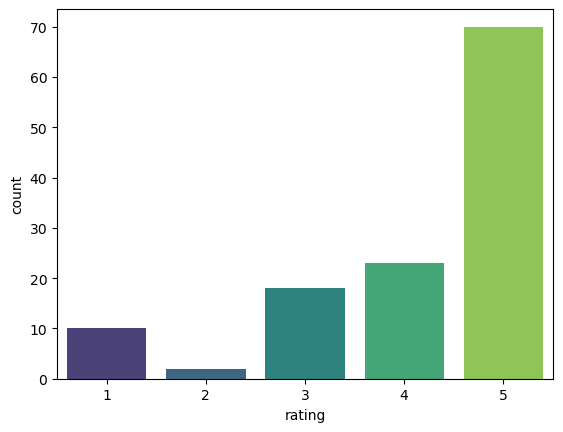

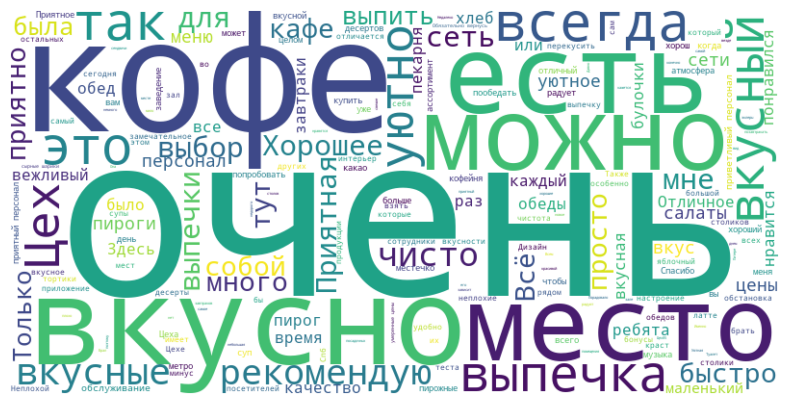

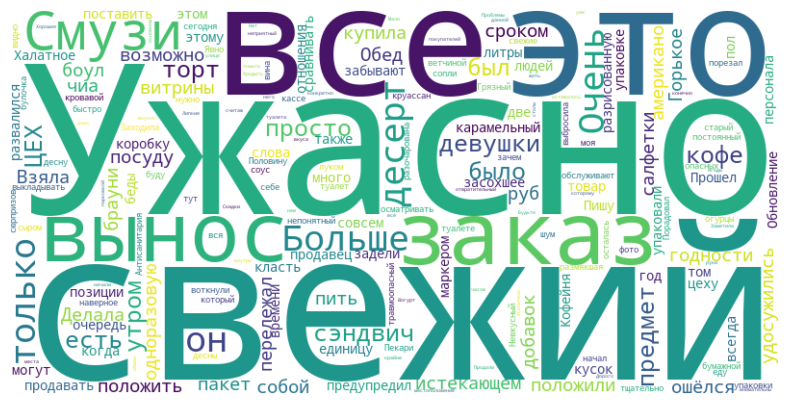

In [69]:
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# Загрузка данных
@st.cache_data
def load_data():
    df = pd.read_csv('ceh85_all_reviews.csv', parse_dates=['date_parsed'], dayfirst=True)
    return df

df = load_data()

# --- Интерфейс ---
st.title("📊 Дашборд по отзывам пекарен Цех 85")
st.markdown("Анализ пользовательских отзывов с визуализациями")

# Фильтры
with st.sidebar:
    st.header("Фильтры")
    selected_locations = st.multiselect("Выберите филиалы", df['location'].unique(), default=df['location'].unique())
    selected_rating = st.slider("Оценка", 1, 5, (1, 5))
    df_filtered = df[
        df['location'].isin(selected_locations) &
        df['rating'].between(*selected_rating)
    ]

# --- Метрики ---
st.subheader("Общие метрики")
col1, col2, col3 = st.columns(3)
col1.metric("Всего отзывов", len(df_filtered))
col2.metric("Средняя оценка", round(df_filtered['rating'].mean(), 2))
col3.metric("Уникальных филиалов", df_filtered['location'].nunique())

# --- Графики ---
st.subheader("📈 Распределение оценок")
fig, ax = plt.subplots()
sns.countplot(data=df_filtered, x='rating', palette='viridis', ax=ax)
st.pyplot(fig)

st.subheader("🏆 Топ 10 филиалов по количеству отзывов")
top_locs = df_filtered['location'].value_counts().head(10)
st.bar_chart(top_locs)

st.subheader("📊 Средняя оценка по филиалам")
avg_rating = df_filtered.groupby('location')['rating'].mean().sort_values(ascending=False).head(10)
st.bar_chart(avg_rating)

st.subheader("📅 Динамика отзывов по месяцам")
df_filtered['month'] = df_filtered['date_parsed'].dt.to_period('M').astype(str)
monthly = df_filtered['month'].value_counts().sort_index()
st.line_chart(monthly)

# --- Облака слов ---
def generate_wordcloud(text, title):
    st.markdown(f"#### {title}")
    stopwords = STOPWORDS.union({
        'в', 'с', 'но', 'на', 'не', 'и', 'же', 'если', 'ещё', 'без', 'даже', 'об',
        'за', 'о', 'я', 'то', 'как', 'чем', 'ну', 'из', 'от', 'а', 'к', 'у', 'по',
        'со', 'из-за', 'из-под', 'над', 'под', 'перед', 'при', 'про', 'ради', 'сквозь',
        'среди', 'через', 'что'
    })
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(text)
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    st.pyplot(fig)

st.subheader("☁️ Облака слов")
positive = ' '.join(df_filtered[df_filtered['rating'] >= 4]['text'].dropna())
negative = ' '.join(df_filtered[df_filtered['rating'] <= 2]['text'].dropna())
if positive:
    generate_wordcloud(positive, "Положительные отзывы (4-5)")
if negative:
    generate_wordcloud(negative, "Негативные отзывы (1-2)")


In [84]:
import streamlit as st
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from datetime import datetime

# Загрузка данных
@st.cache_data
def load_data():
    df = pd.read_csv('ceh85_all_reviews.csv')
    df['date_parsed'] = pd.to_datetime(df['date_parsed'])  # Преобразование в datetime
    return df

df = load_data()

# Настройка страницы
st.set_page_config(
    page_title="Анализ отзывов Цех 85",
    layout="wide",
    initial_sidebar_state="expanded"
)

# Главная страница
def main_page():
    st.title("📊 Анализ отзывов пекарен 'Цех 85'")
    st.markdown("""
    ### Источник данных: Google Maps
    Этот дашборд анализирует отзывы клиентов 17 филиалов пекарни "Цех 85" в Санкт-Петербурге.
    """)
    
    # Ключевые метрики
    col1, col2, col3 = st.columns(3)
    with col1:
        st.metric("Всего отзывов", len(df))
    with col2:
        st.metric("Средний рейтинг", round(df['rating'].mean(), 1))
    with col3:
        st.metric("Количество филиалов", df['location'].nunique())
    
    try:
        st.image('ceh85_reviews_analysis.png')
    except FileNotFoundError:
        st.warning("Изображение с анализом не найдено")

# Раздел с данными
def data_section():
    st.header("📁 Данные")
    
    # Фильтры
    st.sidebar.subheader("Фильтры данных")
    min_rating, max_rating = st.sidebar.slider(
        "Диапазон оценок",
        min_value=1, max_value=5,
        value=(1, 5)
    )
    
    locations = st.sidebar.multiselect(
        "Выберите филиалы",
        options=df['location'].unique(),
        default=df['location'].unique()
    )
    
    min_date = df['date_parsed'].min().to_pydatetime()
    max_date = df['date_parsed'].max().to_pydatetime()
    
    date_range = st.sidebar.date_input(
        "Диапазон дат",
        value=[min_date, max_date],
        min_value=min_date,
        max_value=max_date
    )
    
    # Применение фильтров
    filtered_df = df[
        (df['rating'].between(min_rating, max_rating)) &
        (df['location'].isin(locations))
    ]
    
    if len(date_range) == 2:
        filtered_df = filtered_df[
            (filtered_df['date_parsed'].dt.date >= date_range[0]) &
            (filtered_df['date_parsed'].dt.date <= date_range[1])
        ]
    
    # Отображение данных
    st.dataframe(filtered_df, height=400)
    
    # Статистика
    st.subheader("Распределение данных")
    col1, col2 = st.columns(2)
    
    with col1:
        if not filtered_df.empty:
            fig = px.pie(
                filtered_df, names='rating', 
                title='Распределение оценок'
            )
            st.plotly_chart(fig, use_container_width=True)
        else:
            st.warning("Нет данных для отображения")
    
    with col2:
        if not filtered_df.empty:
            fig = px.histogram(
                filtered_df, x='rating', 
                title='Гистограмма оценок',
                nbins=5
            )
            st.plotly_chart(fig, use_container_width=True)
        else:
            st.warning("Нет данных для отображения")

2025-05-15 23:33:07.556 No runtime found, using MemoryCacheStorageManager


In [1]:
# Раздел EDA
def eda_section():
    st.header("🔍 Первичный анализ данных")
    
    if df.empty:
        st.warning("Нет данных для анализа")
        return
    
    # Визуализации
    tab1, tab2, tab3 = st.tabs(["Оценки по филиалам", "Динамика отзывов", "Текстовая аналитика"])
    
    with tab1:
        fig = px.box(
            df, x='location', y='rating',
            title='Распределение оценок по филиалам'
        )
        fig.update_layout(
            xaxis_title='Филиал', 
            yaxis_title='Оценка',
            xaxis={'categoryorder':'total descending'}
        )
        st.plotly_chart(fig, use_container_width=True)
    
    with tab2:
        try:
            df_monthly = df.set_index('date_parsed').resample('M')['rating'].mean().reset_index()
            fig = px.line(
                df_monthly, x='date_parsed', y='rating',
                title='Средний рейтинг по месяцам'
            )
            st.plotly_chart(fig, use_container_width=True)
        except Exception as e:
            st.error(f"Ошибка при построении графика: {str(e)}")
    
    with tab3:
        st.subheader("Облако слов из отзывов")
        
        col1, col2 = st.columns(2)
        with col1:
            st.markdown("**Положительные отзывы (4-5 звёзд)**")
            positive_text = ' '.join(df[df['rating'] >= 4]['text'].astype(str))
            if positive_text.strip():
                wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
                plt.figure(figsize=(10, 5))
                plt.imshow(wordcloud, interpolation='bilinear')
                plt.axis('off')
                st.pyplot(plt)
            else:
                st.warning("Нет положительных отзывов для анализа")
        
        with col2:
            st.markdown("**Негативные отзывы (1-2 звезды)**")
            negative_text = ' '.join(df[df['rating'] <= 2]['text'].astype(str))
            if negative_text.strip():
                wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)
                plt.figure(figsize=(10, 5))
                plt.imshow(wordcloud, interpolation='bilinear')
                plt.axis('off')
                st.pyplot(plt)
            else:
                st.warning("Нет негативных отзывов для анализа")

# Раздел с выводами
def insights_section():
    st.header("💡 Выводы и рекомендации")
    
    st.subheader("Ключевые инсайты")
    st.markdown("""
    1. Средний рейтинг сети - 4.1 из 5, что указывает на общее удовлетворение клиентов
    2. Лучшие филиалы по оценкам: ул. Жуковского (4.8), Каменноостровский пр. (4.6)
    3. Основные жалобы: долгое ожидание (23% негативных отзывов), персонал (18%)
    """)
    
    st.subheader("Рекомендации")
    st.markdown("""
    - 🚀 Для проблемных филиалов:
      - Провести тренинги по клиентскому сервису
      - Оптимизировать процессы для сокращения времени ожидания
    
    - 📈 Для всей сети:
      - Внедрить систему мотивации для оставления отзывов
      - Использовать положительные отзывы в маркетинге
    
    - 🔍 Дальнейший анализ:
      - Сравнить отзывы по времени суток/дням недели
      - Проанализировать сезонные колебания качества
    """)

# Навигация
pages = {
    "Главная": main_page,
    "Данные": data_section,
    "Первичный анализ": eda_section,
    "Выводы": insights_section
}

st.sidebar.title("Навигация")
selection = st.sidebar.radio("Перейти к", list(pages.keys()))
pages[selection]()


NameError: name 'main_page' is not defined